# Models with priors that lack quantiles
In JAXNS the priors are formulated in a base probability measure, that is always the $\mu = U[0,1]$ measure.
In this situation, the push-forward measure is given by the quantile function, i.e. inverse of the cumulative distribution function.

Mathematically, given a measureable space $(\mathcal{X}, \Sigma_1)$ and a measurable function $F : (\mathcal{X}, \Sigma_1) \to ([0, 1], \Sigma_2)$, then the push-forward measure of a base measure $\mu : \Sigma_1 \to \mathbb{R}^+$ is,

$F_*\mu(B) = \mu(F^{-1}(B)) \quad \forall B \in \Sigma_2$.

For strictly monotonic measurable functions, $F$, $\Sigma_1$ and $\Sigma_2$ can simply be the Borel sigma-algebras, and $F^{-1}$ is the quantile function.

When the quantile function is easily computable this opens up a way to treat all our priors in a homogeneous manner, by representing them as transformations from a uniformly distributed RV.

This is attractive, because this turns our model into a dimensionless problem, and in fact, we could think our base measures as having units of probability.

Under this transformation, our evidence calculation becomes (in one dimension),

$Z \triangleq p(y) = \int_{\mathcal{X}} L(x) p(x) \, \mathrm{d} x = \int_0^1 L(F^{-1}(u)) \, \mathrm{d} u$,

where $\mathrm{d}u$ is the Lebesgue measure on $[0,1]$.

This generalises in a straight-forward manner to high dimensions.

## When you don't have a qunatile function

When we don't have a quantile function, then we are not lost.
In this case, we apply a different parametrisation. Namely we choose a different bijective mesaurable function $G:(\mathcal{X}, \Sigma_1) \to ([0,1]], \Sigma_2)$, which does have an easy to compute inverse, $G^{-1}$.

Furthermore, let $F$ and $G$ be absolutely continuous with respect to the base measure, $F \ll \mu$ and $G \ll \mu$ respectively, then they have Radon-Nikodym derivatives, $f \triangleq \frac{\mathrm{d}F}{\mathrm{d} \mu}$ and $g \triangleq \frac{\mathrm{d}G}{\mathrm{d} \mu}$ respectively, which we call the probability densities.

It is then straight-forward to show that,

$Z \triangleq p(y) = \int_{\mathcal{X}} L(x) p(x) \, \mathrm{d} x = \int_0^1 L(G^{-1}(u)) \frac{f(G^{-1}(u))}{g(G^{-1}(u))} \, \mathrm{d} u$.

It then becomes a simple matter to deal with priors lacking a quantile. Importantly, we require the support of $G$ to contain the suppor of $F$, i.e. $F\ll G$.

Note: if you don't care about the scale of the evidence, e.g. you're only doing parameter inference, then $f$ need not be normalised. Another case where it doesn't matter, would be if you're trying different likelihoods, but keeping the priors the same, then relative evidence ratios are all you care about. **However, if you will use the evidence to compare with other models, then it must be normalised either analytically or numerically.**

## Overview

We'll cover the following topics:

1. Two built in priors without quantiles: `GammaPrior` and `StudentTPrior`.
2. How to define your own prior without a quantile, but with a known probability density function.

In [1]:
from jaxns import NestedSampler
from jaxns.prior_transforms import PriorChain, GammaPrior, StudentT, RealPrior, get_shape
from jaxns.internals.shapes import broadcast_shapes
from jaxns import summary, resample
from jaxns import plot_cornerplot, plot_diagnostics
from jax import random, numpy as jnp, vmap
from jax.scipy.special import gammaln
import pylab as plt
import numpy as np

In [2]:
true_k = 1.
true_theta = 0.5

print("True log(Z)=0")


def log_likelihood(gamma):
    """
    Unit likelihood
    """
    return 0.


with PriorChain() as prior_chain:
    gamma = GammaPrior('gamma', true_k, true_theta)

ns = NestedSampler(loglikelihood=log_likelihood,
                   prior_chain=prior_chain)

results = ns(random.PRNGKey(32564))

WARNING[2022-04-06 17:45:29,254]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
WARNING[2022-04-06 17:45:29,335]: Increasing max_samples (100000) by 100 to evenly divide samples_per_step


True log(Z)=0


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/en

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 2139
# samples: 700
# likelihood evals / sample: 3.1
--------
logZ=0.156 +- 0.072
H=2.3
ESS=199
--------
gamma: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
gamma: 0.45 +- 0.51 | 0.04 / 0.27 / 1.11 | 0.37 | 0.0
--------


WARNING[2022-04-06 17:45:37,575]: No handles with labels found to put in legend.
WARNING[2022-04-06 17:45:37,765]: No handles with labels found to put in legend.


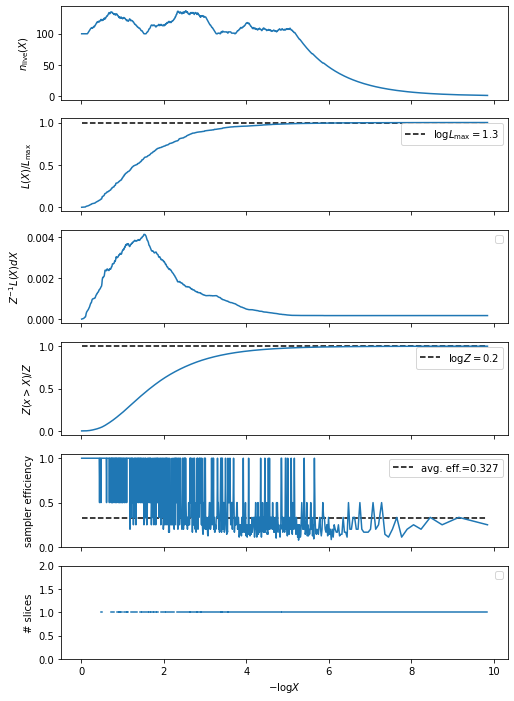

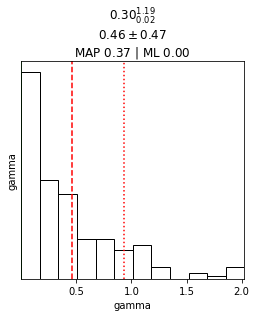

In [3]:
# Summary looks good
summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

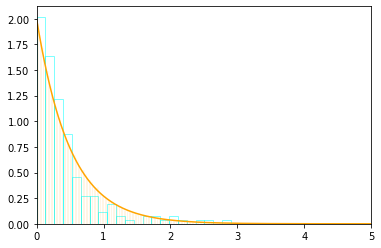

In [4]:
# Posteriors match well
samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['gamma'], bins='auto', ec='cyan', alpha=0.5, density=True, fc='none')

_gamma = np.random.gamma(true_k, true_theta, size=100000)

plt.hist(_gamma, bins='auto', ec='orange', alpha=0.05, density=True, fc='none')


_x = jnp.linspace(0, 5, 1000)
_log_prob = vmap(lambda _x: gamma._log_prob(_x, true_k, true_theta))(_x)
plt.plot(_x,jnp.exp(_log_prob), c='orange')
plt.xlim(0, 5.)

plt.show()

In [5]:
true_nu, true_mu, true_sigma = 2., 0., 1.

print("True log(Z)=0")


def log_likelihood(x, **kwargs):
    """
    Unit likelihood
    """
    return 0.


with PriorChain() as prior_chain:
    x = StudentT('x', true_nu, true_mu, true_sigma)

ns = NestedSampler(loglikelihood=log_likelihood,
                   prior_chain=prior_chain)

results = ns(random.PRNGKey(32564))

/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
WARNING[2022-04-06 17:45:40,499]: Increasing max_samples (100000) by 100 to evenly divide samples_per_step
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/j

True log(Z)=0


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/en

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 3130
# samples: 700
# likelihood evals / sample: 4.5
--------
logZ=0.008 +- 0.042
H=1.2
ESS=162
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.


WARNING[2022-04-06 17:45:47,159]: No handles with labels found to put in legend.
WARNING[2022-04-06 17:45:47,216]: No handles with labels found to put in legend.


x: -0.1 +- 2.6 | -1.9 / -0.1 / 1.5 | 1.6 | -0.0
--------


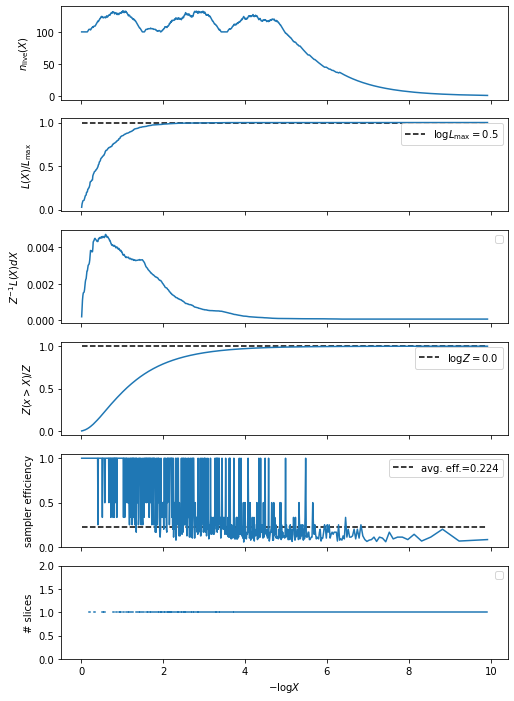

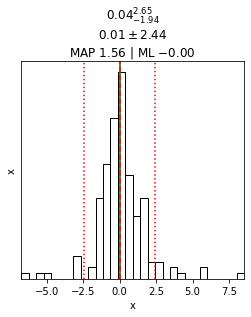

In [6]:

summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

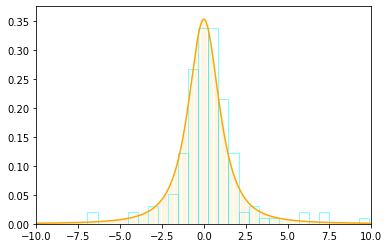

In [7]:

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['x'], bins='auto', ec='cyan', alpha=0.5, density=True, fc='none')

_x = np.random.standard_t(true_nu, size=100000)

plt.hist(_x, bins='auto', ec='orange', alpha=0.05, density=True, fc='none')

_x = jnp.linspace(-10, 10, 1000)
_log_prob = vmap(lambda _x: x._log_prob(_x, true_nu, true_mu, true_sigma))(_x)
plt.plot(_x,jnp.exp(_log_prob), c='orange')
plt.xlim(-10., 10.)

plt.show()

In [8]:
# When there are no quantiles for a prior that you want to implement, then there's an easy way to implement your own Prior.


class GeneralisedGaussianPrior(RealPrior):
    """
    Generalises the Gaussian from L2 norm to Lp.
    """

    def __init__(self, name, mu, alpha, beta, tracked=True):
        """

        Args:
            mu: location
            alpha: scale
            beta: shape
        """
        mu = self._prepare_parameter(name, 'mu', mu)
        alpha = self._prepare_parameter(name, 'alpha', alpha)
        beta = self._prepare_parameter(name, 'beta', beta)
        shape = broadcast_shapes(broadcast_shapes(get_shape(mu), get_shape(alpha)),
                                 get_shape(beta))
        super(GeneralisedGaussianPrior, self).__init__(name, shape, [mu, alpha, beta], tracked)

    def _support_center(self, mu, alpha, beta):
        """
        We return mode, but this is just an estimate.
        """
        return mu

    def _support_width(self, mu, alpha, beta):
        """
        We use the FWHM. But, this is just an estimate.
        """
        fwhm = 2. * alpha * jnp.power(np.log(2.), jnp.reciprocal(beta))
        return fwhm

    def _log_prob(self, X, mu, alpha, beta):
        """
        Generalised Gaussian log-prob.
        """
        return - np.log(2.) + jnp.log(beta) - jnp.log(alpha) - gammaln(jnp.reciprocal(beta)) - jnp.power(
            jnp.abs(X - mu) / alpha, beta)

In [9]:
print("True log(Z)=0")

def log_likelihood(x):
    """
    Unit likelihood
    """
    return 0.


with PriorChain() as prior_chain:
    x = GeneralisedGaussianPrior('x', 0., 1., 1.5)

ns = NestedSampler(loglikelihood=log_likelihood,
                   prior_chain=prior_chain)

results = ns(random.PRNGKey(32564), num_live_points=1000)


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:3035: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
WARNING[2022-04-06 17:45:54,633]: Increasing max_samples (100000) by 100 to evenly divide samples_per_step


True log(Z)=0


/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/envs/jax_py/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:2983: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "asarray")
/home/albert/miniconda3/en

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 12749
# samples: 5900
# likelihood evals / sample: 2.2
--------
logZ=-0.022 +- 0.02
H=1.4
ESS=2210
--------
x: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x: 0.01 +- 0.9 | -1.08 / 0.02 / 1.12 | -0.6 | -0.0
--------


WARNING[2022-04-06 17:46:03,204]: No handles with labels found to put in legend.
WARNING[2022-04-06 17:46:03,386]: No handles with labels found to put in legend.


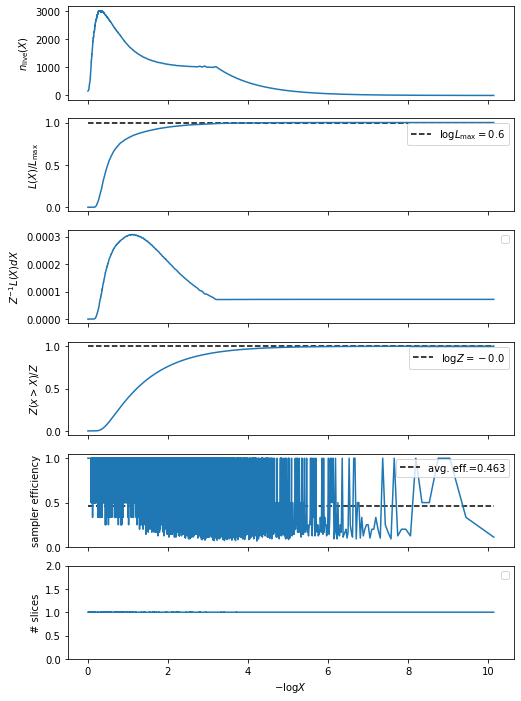

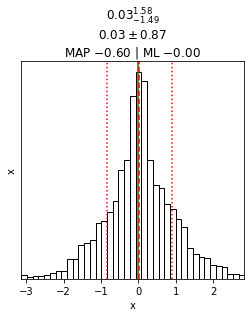

In [10]:
summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

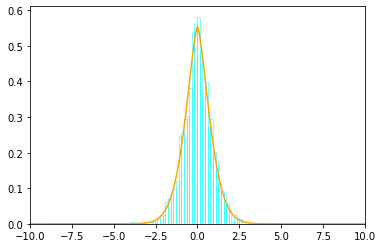

In [11]:

samples = resample(random.PRNGKey(43083245), results.samples, results.log_dp_mean, S=int(results.ESS))

plt.hist(samples['x'], bins='auto', ec='cyan', alpha=0.5, density=True, fc='none')

_x = jnp.linspace(-10, 10, 1000)
_log_prob = vmap(lambda _x: x._log_prob(_x, 0., 1., 1.5))(_x)
plt.plot(_x,jnp.exp(_log_prob), c='orange')
plt.xlim(-10., 10.)
plt.show()